In [7]:
###-----------------
### Import Libraries
###-----------------

from helper import *
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
#import torch.nn.functional as F
#from torch.autograd import Variable
from torchsummary import summary
from torchvision import transforms,datasets
from torch.utils.data import DataLoader,Dataset,random_split

from PIL import Image
from sklearn.cluster import KMeans

import tensorflow as tf
from helper import fn_plot_torch_hist, fn_plot_confusion_matrix


%matplotlib inline

In [8]:
###----------------------
### Some basic parameters
###----------------------

inpDir = os.path.join( '..', 'input') # location where input data is stored
outDir = '../output' # location to store outputs
subDir = 'cityscapes_data' # location of the images
modelDir = 'Neural Network' # location to save model files
#valDir = 'valid_flowers' # location related to this dataset
altName = 'unet_city' # Model file name for this alternative

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
#tf.random.set_seed(RANDOM_STATE)


EPOCHS = 10   # number of cycles to run
ALPHA = 0.001
BATCH_SIZE = 16
TRAIN_SIZE = 0.8
IMG_HEIGHT = 188
IMG_WIDTH = 188


# Transformations
# flipping
FLIP_MODE = "horizontal_and_vertical"
# Rotation
ROTATION_FACTOR = (-0.1, 0.1)
# filling mode
FILL_MODE = 'nearest'


## Early Stopping
ES_PATIENCE = 20 # if performance does not improve stop
# Learning rates
LR_PATIENCE = 10 # if performace is not improving reduce alpha
LR_FACTOR = 0.5 # rate of reduction of alpha
PATIENCE = 5

# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (15,8),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

In [9]:
###------------------
### Memory Management
###------------------

physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f'GPUs {physical_devices}')
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
    except RuntimeError: pass
    
tf.keras.backend.clear_session()

In [10]:
X = np.asarray([[1,2], [3,4]])
X

array([[1, 2],
       [3, 4]])

In [11]:
# reshape in to 4 dim {batch x height x width x channel}

X = X.reshape(1,2,2,1)
X

array([[[[1],
         [2]],

        [[3],
         [4]]]])

In [13]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Conv2DTranspose(1, (1,1), 
                                          strides = 2,
                                          input_shape = (2,2,1)))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTr  (None, 4, 4, 1)           2         
 anspose)                                                        
                                                                 
Total params: 2 (8.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
weights = [np.asarray([[[[0.1]]]]), np.asarray([0])]

model.set_weights(weights)

y_hat = model.predict(X)

1/1 [==============================] - 0s 76ms/step


In [16]:
y_hat = y_hat.reshape((4,4))
y_hat

array([[0.1, 0. , 0.2, 0. ],
       [0. , 0. , 0. , 0. ],
       [0.3, 0. , 0.4, 0. ],
       [0. , 0. , 0. , 0. ]], dtype=float32)

In [4]:
def fn_plot_label(tr_ds,ts_ds):
  plt.figure(figsize = (15,5))

  plt.subplot(1,2,1)

  train_labels = tf.concat([lbl for img, lbl in tr_ds],axis = 0).numpy()

  unique,_,counts=tf.unique_with_counts(train_labels)

  plt.bar(range(len(unique)),counts ,align='center',color = 'DarkBlue')

  plt.xticks(range(len(unique)),class_names)

  plt.title('Training Set')

  plt.subplot(1,2,2)

  test_labels = tf.concat([lbl for img, lbl in ts_ds],axis = 0).numpy()

  unique,_,counts = tf.unique_with_counts(test_labels)

  plt.bar(range(len(unique)),counts ,align='center',color = 'Orange')

  plt.xticks(range(len(unique)),class_names)

  plt.title('Test Set')







In [5]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                  fname='flower_photos',
                                  untar=True)
data_dir = pathlib.Path(data_dir)

In [6]:
data_dir

WindowsPath('C:/Users/duasp/.keras/datasets/flower_photos')

In [7]:
# list content of data_dir
os.listdir(data_dir)

['daisy', 'dandelion', 'LICENSE.txt', 'roses', 'sunflowers', 'tulips']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='training',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=TEST_SIZE,
    subset='validation',
    seed= RANDOM_STATE,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)


Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
class_names = train_ds.class_names
num_classes = len(class_names)
print('total ', num_classes, class_names)

total  5 ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


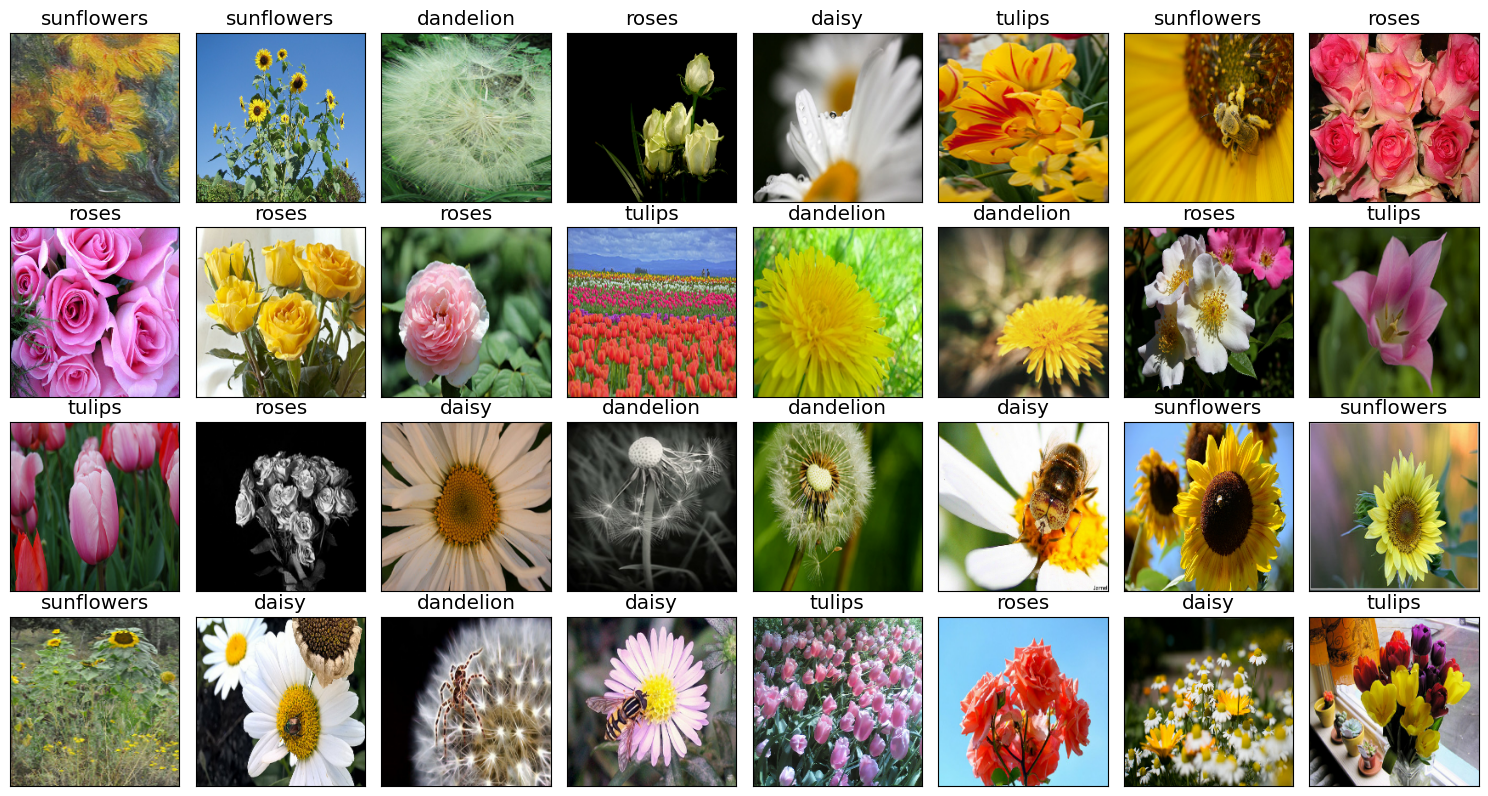

In [10]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

# take one batch of the dataset
for images, labels in train_ds.take(1):

    # iterate through the batch
    for i in range(BATCH_SIZE):

        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure

        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8"))

        # display class in the title
        ax.set_title(class_names[labels[i]])

# fit the subplot(s) in to the figure area
plt.tight_layout()

# display all open images
plt.show()

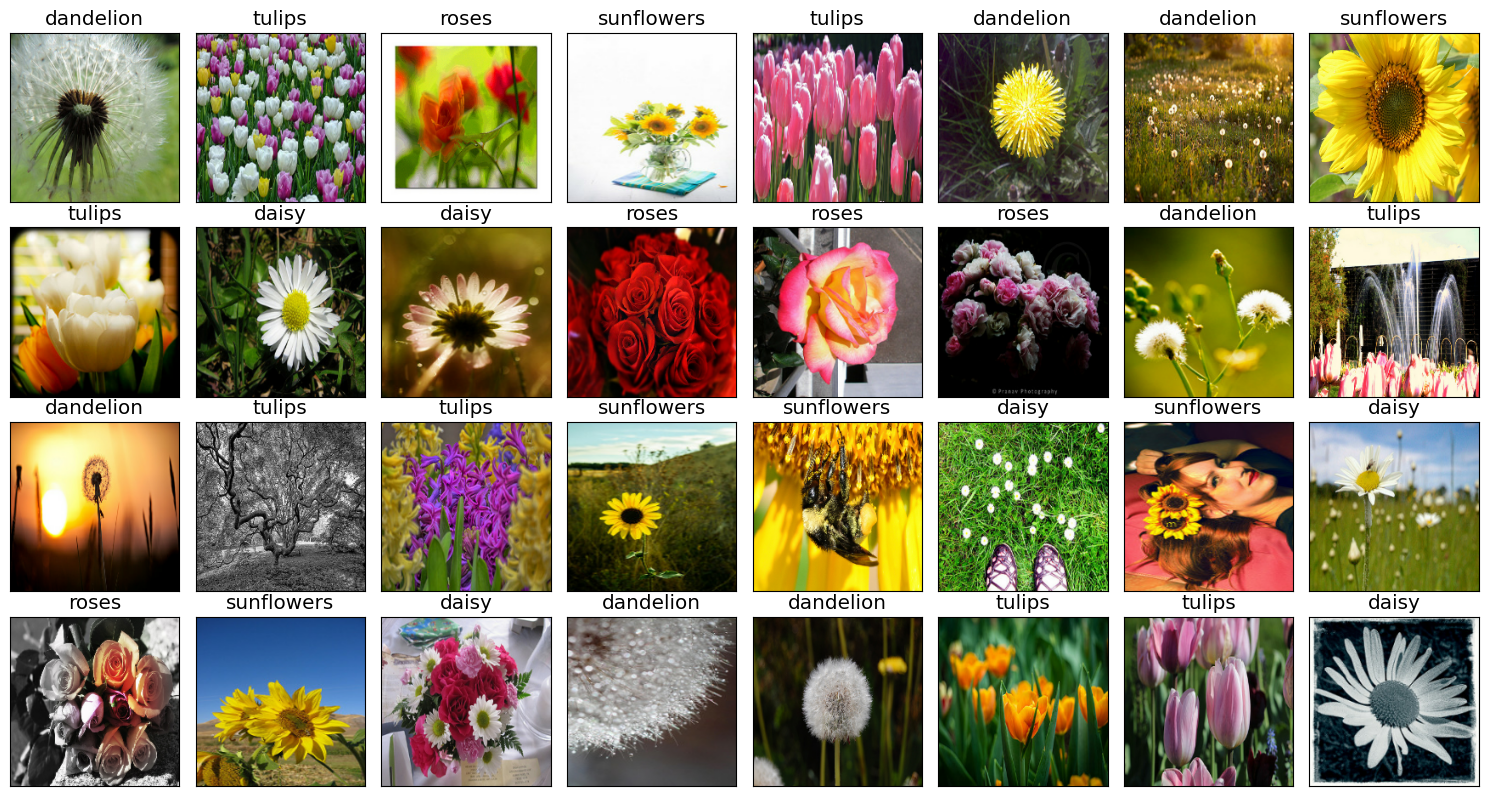

In [11]:
# set figure size
fig = plt.figure()  # figure size in inches with default params

# Adjust the subplot layout parameters.
fig.subplots_adjust(left=0., # as a fraction of the figure width
                    right=1., # use full width, as a fraction of the figure width
                    bottom=0., # as a fraction of the figure height
                    top=1., # as a fraction of the figure height
                    hspace=0.05, # as a fraction of the average Axes height
                    wspace=0.05) # width of the padding between subplots

# take one batch of the dataset
for images, labels in test_ds.take(1):

    # iterate through the batch
    for i in range(BATCH_SIZE):

        # add a subplot
        ax = fig.add_subplot( BATCH_SIZE//8, 8, (i+1), xticks=[], yticks=[]) # add a subplot to the figure

        # image_size may have converted these images to float
        ax.imshow(images[i].numpy().astype("uint8"))

        # display class in the title
        ax.set_title(class_names[labels[i]])

# fit the subplot(s) in to the figure area
plt.tight_layout()

# display all open images
plt.show()

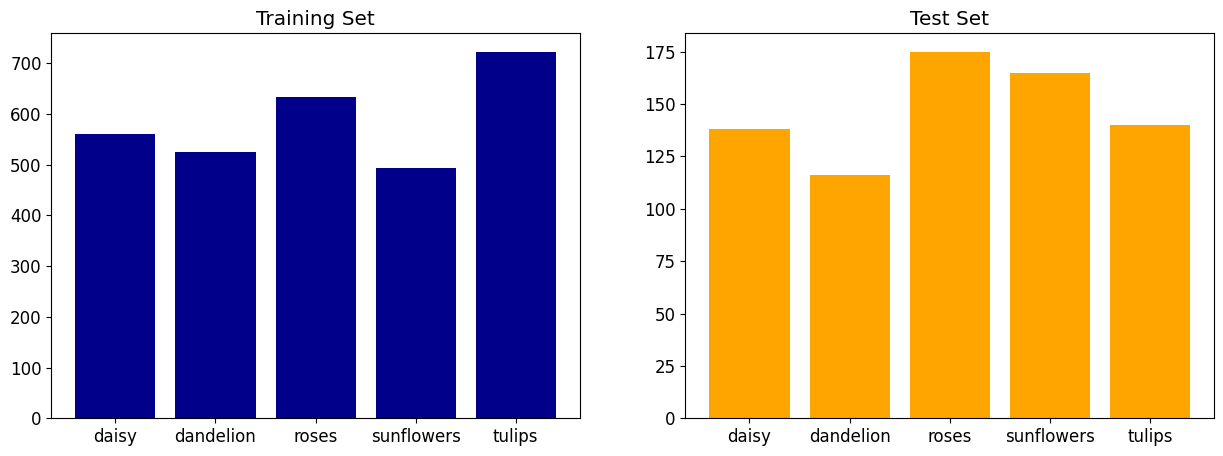

In [12]:
# how many examples in each of the class

fn_plot_label(train_ds, test_ds)


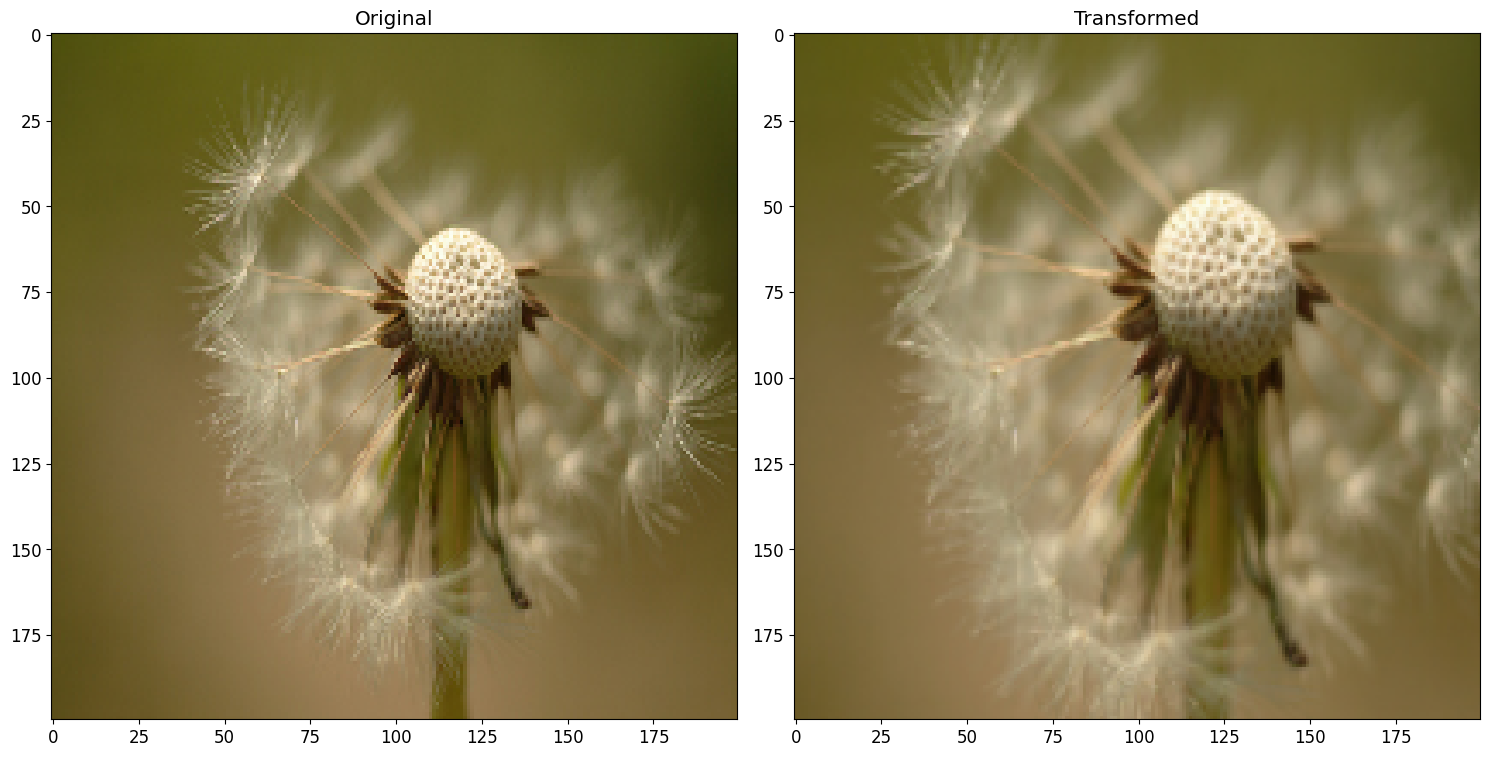

In [13]:
layer =  tf.keras.layers.RandomZoom(height_factor=(-0.2,-0.2), width_factor=(-0.2,-0.2))
plt.figure()
img_num = 3
for images, labels in train_ds.take(1):
   out_images = layer(images)
   plt.subplot(1, 2, 1)
   plt.title('Original')

   plt.imshow(images[img_num].numpy().astype("uint8"))
   plt.subplot(1, 2, 2)
   plt.title('Transformed')
   plt.imshow(out_images[img_num].numpy().astype("uint8"))
plt.tight_layout()
plt.show()

In [14]:
train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [15]:
from tensorflow.keras.applications import DenseNet169

In [16]:
densenet_model = DenseNet169(weights = 'imagenet',
                             include_top = False,
                             input_shape = (IMG_HEIGHT, IMG_WIDTH, 3))

In [17]:
for layer in densenet_model.layers:
    layer.trainable = False

In [18]:
densenet_model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 200, 200, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 206, 206, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 100, 100, 64)         9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 100, 100, 64)         256       ['conv1/conv[0][0]']

 conv2_block4_0_bn (BatchNo  (None, 50, 50, 160)          640       ['conv2_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block4_0_relu (Activ  (None, 50, 50, 160)          0         ['conv2_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_block4_1_conv (Conv2  (None, 50, 50, 128)          20480     ['conv2_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv2_block4_1_bn (BatchNo  (None, 50, 50, 128)          512       ['conv2_block4_1_conv[0][0]'] 
 rmalizati

 rmalization)                                                                                     
                                                                                                  
 conv3_block1_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block1_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block1_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block1_concat (Conca  (None, 25, 25, 160)          0         ['pool2_pool[0][0]',          
 tenate)                                                             'conv3_block1_2_conv[0][0]'] 
          

 conv3_block5_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block5_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block5_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block5_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block5_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block5_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block5_concat (Conca  (None, 25, 25, 288)          0         ['conv3_block4_concat[0][0]', 
 tenate)  

                                                                                                  
 conv3_block9_1_bn (BatchNo  (None, 25, 25, 128)          512       ['conv3_block9_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block9_1_relu (Activ  (None, 25, 25, 128)          0         ['conv3_block9_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv3_block9_2_conv (Conv2  (None, 25, 25, 32)           36864     ['conv3_block9_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_blo

 pool3_pool (AveragePooling  (None, 12, 12, 256)          0         ['pool3_conv[0][0]']          
 2D)                                                                                              
                                                                                                  
 conv4_block1_0_bn (BatchNo  (None, 12, 12, 256)          1024      ['pool3_pool[0][0]']          
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_0_relu (Activ  (None, 12, 12, 256)          0         ['conv4_block1_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_1_conv (Conv2  (None, 12, 12, 128)          32768     ['conv4_block1_0_relu[0][0]'] 
 D)       

                                                                                                  
 conv4_block4_concat (Conca  (None, 12, 12, 384)          0         ['conv4_block3_concat[0][0]', 
 tenate)                                                             'conv4_block4_2_conv[0][0]'] 
                                                                                                  
 conv4_block5_0_bn (BatchNo  (None, 12, 12, 384)          1536      ['conv4_block4_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block5_0_relu (Activ  (None, 12, 12, 384)          0         ['conv4_block5_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block8_concat (Conca  (None, 12, 12, 512)          0         ['conv4_block7_concat[0][0]', 
 tenate)                                                             'conv4_block8_2_conv[0][0]'] 
                                                                                                  
 conv4_block9_0_bn (BatchNo  (None, 12, 12, 512)          2048      ['conv4_block8_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block9_0_relu (Activ  (None, 12, 12, 512)          0         ['conv4_block9_0_bn[0][0]']   
 ation)                                                                                           
          

 conv4_block12_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block12_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block12_concat (Conc  (None, 12, 12, 640)          0         ['conv4_block11_concat[0][0]',
 atenate)                                                            'conv4_block12_2_conv[0][0]']
                                                                                                  
 conv4_block13_0_bn (BatchN  (None, 12, 12, 640)          2560      ['conv4_block12_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_block13_0_relu (Acti  (None, 12, 12, 640)          0         ['conv4_block13_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv4_block16_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block16_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block16_concat (Conc  (None, 12, 12, 768)          0         ['conv4_block15_concat[0][0]',
 atenate)                                                            'conv4_block16_2_conv[0][0]']
                                                                                                  
 conv4_block17_0_bn (BatchN  (None, 12, 12, 768)          3072      ['conv4_block16_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv4_blo

 vation)                                                                                          
                                                                                                  
 conv4_block20_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block20_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block20_concat (Conc  (None, 12, 12, 896)          0         ['conv4_block19_concat[0][0]',
 atenate)                                                            'conv4_block20_2_conv[0][0]']
                                                                                                  
 conv4_block21_0_bn (BatchN  (None, 12, 12, 896)          3584      ['conv4_block20_concat[0][0]']
 ormalization)                                                                                    
          

 conv4_block24_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block24_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block24_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block24_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block24_concat (Conc  (None, 12, 12, 1024)         0         ['conv4_block23_concat[0][0]',
 atenate)                                                            'conv4_block24_2_conv[0][0]']
                                                                                                  
 conv4_block25_0_bn (BatchN  (None, 12, 12, 1024)         4096      ['conv4_block24_concat[0][0]']
 ormalizat

                                                                                                  
 conv4_block28_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block28_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block28_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block28_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block28_concat (Conc  (None, 12, 12, 1152)         0         ['conv4_block27_concat[0][0]',
 atenate)                                                            'conv4_block28_2_conv[0][0]']
                                                                                                  
 conv4_blo

 ormalization)                                                                                    
                                                                                                  
 conv4_block32_1_relu (Acti  (None, 12, 12, 128)          0         ['conv4_block32_1_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv4_block32_2_conv (Conv  (None, 12, 12, 32)           36864     ['conv4_block32_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv4_block32_concat (Conc  (None, 12, 12, 1280)         0         ['conv4_block31_concat[0][0]',
 atenate)                                                            'conv4_block32_2_conv[0][0]']
          

                                                                                                  
 conv5_block4_0_bn (BatchNo  (None, 6, 6, 736)            2944      ['conv5_block3_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block4_0_relu (Activ  (None, 6, 6, 736)            0         ['conv5_block4_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block4_1_conv (Conv2  (None, 6, 6, 128)            94208     ['conv5_block4_0_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_blo

 tenate)                                                             'conv5_block7_2_conv[0][0]'] 
                                                                                                  
 conv5_block8_0_bn (BatchNo  (None, 6, 6, 864)            3456      ['conv5_block7_concat[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block8_0_relu (Activ  (None, 6, 6, 864)            0         ['conv5_block8_0_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block8_1_conv (Conv2  (None, 6, 6, 128)            110592    ['conv5_block8_0_relu[0][0]'] 
 D)                                                                                               
          

 conv5_block11_concat (Conc  (None, 6, 6, 992)            0         ['conv5_block10_concat[0][0]',
 atenate)                                                            'conv5_block11_2_conv[0][0]']
                                                                                                  
 conv5_block12_0_bn (BatchN  (None, 6, 6, 992)            3968      ['conv5_block11_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block12_0_relu (Acti  (None, 6, 6, 992)            0         ['conv5_block12_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_block12_1_conv (Conv  (None, 6, 6, 128)            126976    ['conv5_block12_0_relu[0][0]']
 2D)      

                                                                                                  
 conv5_block15_concat (Conc  (None, 6, 6, 1120)           0         ['conv5_block14_concat[0][0]',
 atenate)                                                            'conv5_block15_2_conv[0][0]']
                                                                                                  
 conv5_block16_0_bn (BatchN  (None, 6, 6, 1120)           4480      ['conv5_block15_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block16_0_relu (Acti  (None, 6, 6, 1120)           0         ['conv5_block16_0_bn[0][0]']  
 vation)                                                                                          
                                                                                                  
 conv5_blo

 2D)                                                                                              
                                                                                                  
 conv5_block19_concat (Conc  (None, 6, 6, 1248)           0         ['conv5_block18_concat[0][0]',
 atenate)                                                            'conv5_block19_2_conv[0][0]']
                                                                                                  
 conv5_block20_0_bn (BatchN  (None, 6, 6, 1248)           4992      ['conv5_block19_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block20_0_relu (Acti  (None, 6, 6, 1248)           0         ['conv5_block20_0_bn[0][0]']  
 vation)                                                                                          
          

 conv5_block23_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block23_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block23_concat (Conc  (None, 6, 6, 1376)           0         ['conv5_block22_concat[0][0]',
 atenate)                                                            'conv5_block23_2_conv[0][0]']
                                                                                                  
 conv5_block24_0_bn (BatchN  (None, 6, 6, 1376)           5504      ['conv5_block23_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_block24_0_relu (Acti  (None, 6, 6, 1376)           0         ['conv5_block24_0_bn[0][0]']  
 vation)  

                                                                                                  
 conv5_block27_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block27_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block27_concat (Conc  (None, 6, 6, 1504)           0         ['conv5_block26_concat[0][0]',
 atenate)                                                            'conv5_block27_2_conv[0][0]']
                                                                                                  
 conv5_block28_0_bn (BatchN  (None, 6, 6, 1504)           6016      ['conv5_block27_concat[0][0]']
 ormalization)                                                                                    
                                                                                                  
 conv5_blo

 vation)                                                                                          
                                                                                                  
 conv5_block31_2_conv (Conv  (None, 6, 6, 32)             36864     ['conv5_block31_1_relu[0][0]']
 2D)                                                                                              
                                                                                                  
 conv5_block31_concat (Conc  (None, 6, 6, 1632)           0         ['conv5_block30_concat[0][0]',
 atenate)                                                            'conv5_block31_2_conv[0][0]']
                                                                                                  
 conv5_block32_0_bn (BatchN  (None, 6, 6, 1632)           6528      ['conv5_block31_concat[0][0]']
 ormalization)                                                                                    
          

In [19]:
def build_model(d_model):
    dor1 = 0.1
    dor2 = 0.18
    dor3 = 0.28
    dor4 = 0.37
    dor5 = 0.46
    dor6 = 0.54
    dor7 = 0.62
    
    #l2 = tf.keras.regularizers.L2(0.001)
    #krnl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Rescaling(1./255.))

    # Data Augumentation

    model.add(tf.keras.layers.RandomFlip(mode = FLIP_MODE, seed = RANDOM_STATE)),

    model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR, seed = RANDOM_STATE)),

    #model.add(tf.keras.layers.RandomCrop(190, 190, seed = RANDOM_STATE))

    ####set1####
    #cov 1
    model.add(d_model)
   
    
    ### head ###

    model.add(tf.keras.layers.Flatten())     
    model.add(tf.keras.layers.Dense(1664))       
    model.add(tf.keras.layers.BatchNormalization())      # bn layer
    model.add(tf.keras.layers.Activation('relu'))        # activation layer
    model.add(tf.keras.layers.Dropout(0.1))
    model.add(tf.keras.layers.Dense(num_classes))

    model.compile(optimizer='adam',
                  loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    return model

In [20]:
model = build_model(densenet_model)

In [21]:
'''# def build_model():
dor1 = 0.1
dor2 = 0.18
dor3 = 0.28
dor4 = 0.37
dor5 = 0.46
dor6 = 0.54
dor7 = 0.62
l2 = tf.keras.regularizers.L2(0.001)
krnl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Rescaling(1./255.))

# Data Augumentation

#model.add(tf.keras.layers.RandomFlip(mode = FLIP_MODE, seed = RANDOM_STATE)),

#model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR, fill_mode = FILL_MODE, seed = RANDOM_STATE)),

model.add(tf.keras.layers.RandomCrop(190, 190, seed = RANDOM_STATE))

####set1####
#cov 1
model.add(tf.keras.layers.Conv2D(8,(3,3),kernel_regularizer = l2)) # 188 X 188
#model.add(tf.keras.layers.BatchNormalization()) # bn layer
model.add(tf.keras.layers.Activation('leaky_relu'))# activation layer
model.add(tf.keras.layers.MaxPool2D((2,2)))  # output shape = 94,94,8
model.add(tf.keras.layers.Dropout(dor1))
#model.add(tf.keras.layers.Dropout(dor2))
#maxpool 1


####set2####
#cov 2
model.add(tf.keras.layers.Conv2D(16,(3,3),kernel_regularizer = l2))  # 92x92x16
#model.add(tf.keras.layers.BatchNormalization()) # bn layer
model.add(tf.keras.layers.Activation('leaky_relu'))# activation layer
#maxpool 2
model.add(tf.keras.layers.MaxPool2D((2,2)))  #pool_size=(2, 2),strides=None,padding='same'  #6x6x64 filter is 64
model.add(tf.keras.layers.Dropout(dor2))


####set3####
#cov 3
model.add(tf.keras.layers.Conv2D(32,(3,3),kernel_regularizer = l2)) ###44 X 44X32
#model.add(tf.keras.layers.BatchNormalization()) # bn layer
model.add(tf.keras.layers.Activation('leaky_relu'))# activation layer
model.add(tf.keras.layers.MaxPool2D((2,2))) # output = 22,22,32
model.add(tf.keras.layers.Dropout(dor3))

##3head###

model.add(tf.keras.layers.Conv2D(64,(3,3),kernel_regularizer = l2)) ###20 X 20 X64
#model.add(tf.keras.layers.BatchNormalization()) # bn layer
model.add(tf.keras.layers.Activation('leaky_relu'))# activation layer
model.add(tf.keras.layers.MaxPool2D((2,2))) # output = 10,10,64
model.add(tf.keras.layers.Dropout(dor4))


model.add(tf.keras.layers.Conv2D(128,(3,3),kernel_regularizer = l2)) ###8 X 8 128
#model.add(tf.keras.layers.BatchNormalization()) # bn layer
model.add(tf.keras.layers.Activation('leaky_relu'))# activation layer
model.add(tf.keras.layers.MaxPool2D((2,2))) # output = 4,4,128
model.add(tf.keras.layers.Dropout(dor5))


model.add(tf.keras.layers.Conv2D(256,(3,3),kernel_regularizer = l2)) ###2 X 2 X256
#model.add(tf.keras.layers.BatchNormalization()) # bn layer
model.add(tf.keras.layers.Activation('leaky_relu'))# activation layer
model.add(tf.keras.layers.Dropout(dor6))

### head ###

model.add(tf.keras.layers.Flatten())### output =  1024
model.add(tf.keras.layers.Dense(256)) ###1024/4
#model.add(tf.keras.layers.BatchNormalization()) # bn layer
model.add(tf.keras.layers.Activation('leaky_relu'))# activation layer
model.add(tf.keras.layers.Dropout(dor7))
model.add(tf.keras.layers.Dense(num_classes))

model.compile(optimizer='adam',loss =  tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=['accuracy'])
'''

"# def build_model():\ndor1 = 0.1\ndor2 = 0.18\ndor3 = 0.28\ndor4 = 0.37\ndor5 = 0.46\ndor6 = 0.54\ndor7 = 0.62\nl2 = tf.keras.regularizers.L2(0.001)\nkrnl_init = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)\n\nmodel = tf.keras.Sequential()\nmodel.add(tf.keras.layers.Rescaling(1./255.))\n\n# Data Augumentation\n\n#model.add(tf.keras.layers.RandomFlip(mode = FLIP_MODE, seed = RANDOM_STATE)),\n\n#model.add(tf.keras.layers.RandomRotation(ROTATION_FACTOR, fill_mode = FILL_MODE, seed = RANDOM_STATE)),\n\nmodel.add(tf.keras.layers.RandomCrop(190, 190, seed = RANDOM_STATE))\n\n####set1####\n#cov 1\nmodel.add(tf.keras.layers.Conv2D(8,(3,3),kernel_regularizer = l2)) # 188 X 188\n#model.add(tf.keras.layers.BatchNormalization()) # bn layer\nmodel.add(tf.keras.layers.Activation('leaky_relu'))# activation layer\nmodel.add(tf.keras.layers.MaxPool2D((2,2)))  # output shape = 94,94,8\nmodel.add(tf.keras.layers.Dropout(dor1))\n#model.add(tf.keras.layers.Dropout(dor2))\n#maxpool 1\n\n\n####s

In [22]:
checkpoint_path = ('all_in.weights.h5')


model_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      verbose=1,
                                                      mode = 'min',
                                                      monitor='val_loss',
                                                      save_best_only=True,
                                                      save_weights_only=True)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                               min_delta=0,
                                               mode = 'auto',
                                               patience=PATIENCE,
                                               verbose=1,
                                               restore_best_weights=True)
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                factor=LR_FACTOR,
                                                  mode = 'auto',
                                                patience=LR_PATIENCE,
                                                verbose=1)




In [23]:
history = model.fit(train_ds ,callbacks = [model_callback,early_stopping_callback,lr_decay],
                    batch_size = BATCH_SIZE,
                    validation_data =[test_ds],
                    epochs = EPOCHS,verbose = 1)

Epoch 1/100


92/92 [==============================] - ETA: 0s - loss: 0.8616 - accuracy: 0.7973
Epoch 1: val_loss improved from inf to 0.81338, saving model to all_in.weights.h5
92/92 [==============================] - 120s 1s/step - loss: 0.8616 - accuracy: 0.7973 - val_loss: 0.8134 - val_accuracy: 0.8283 - lr: 0.0010
Epoch 2/100
92/92 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.9016
Epoch 2: val_loss improved from 0.81338 to 0.39543, saving model to all_in.weights.h5
92/92 [==============================] - 109s 1s/step - loss: 0.3016 - accuracy: 0.9016 - val_loss: 0.3954 - val_accuracy: 0.8760 - lr: 0.0010
Epoch 3/100
92/92 [==============================] - ETA: 0s - loss: 0.1945 - accuracy: 0.9292
Epoch 3: val_loss improved from 0.39543 to 0.35425, saving model to all_in.weights.h5
92/92 [==============================] - 109s 1s/step - loss: 0.1945 - accuracy: 0.9292 - val_loss: 0.3542 - val_accuracy: 0.8896 - lr: 0.0010
Epoch 4/100
92/92 [===========

In [24]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 200, 200, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 200, 200, 3)       0         
 ation)                                                          
                                                                 
 densenet169 (Functional)    (None, 6, 6, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 59904)             0         
                                                                 
 dense (Dense)               (None, 1664)              99681920  
                                                        

In [25]:
loss_df = pd.DataFrame(history.history)
loss_df.head()

loss  accuracy  val_loss  val_accuracy     lr
0  0.861579  0.797343  0.813379      0.828338  0.001
1  0.301570  0.901567  0.395430      0.876022  0.001
2  0.194525  0.929155  0.354246      0.889646  0.001
3  0.140002  0.949591  0.419729      0.880109  0.001
4  0.118015  0.958106  0.420071      0.895095  0.001

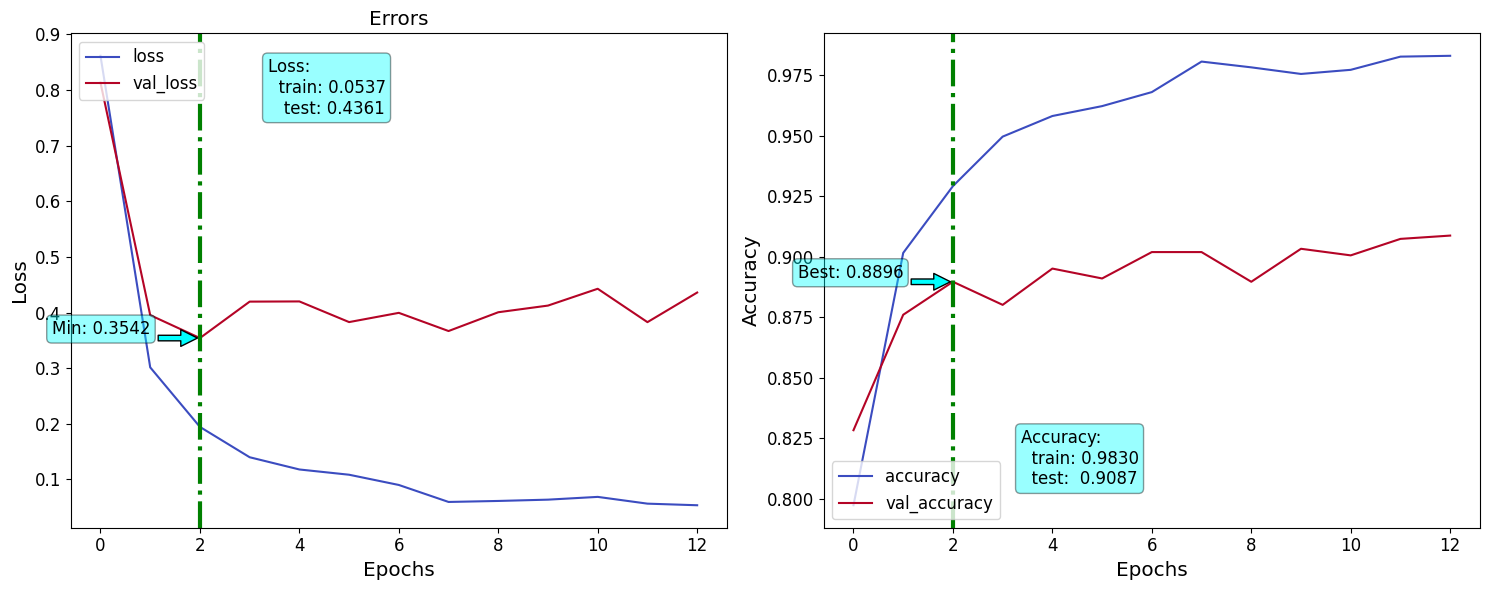

In [26]:
fn_plot_tf_hist(loss_df)

In [27]:
test_loss, test_acc = model.evaluate(test_ds, verbose = 2)
print('\nTest accuracy:', test_acc)

23/23 - 13s - loss: 0.3542 - accuracy: 0.8896 - 13s/epoch - 559ms/step

Test accuracy: 0.8896457552909851
